<a href="https://colab.research.google.com/github/afraa-n/XAI-DL/blob/main/XAI_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning: MNIST Digit Classification Analysis
### Name: Afraa Noureen

## 1. Introduction
In this analysis, we explore the interpretability of deep learning models by examining how a CNN processes and distinguishes between digits 1 and 7 in the MNIST dataset. We use occlusion saliency mapping to understand which spatial regions are most important for the model's classification decisions.

## 2. Hypothesis
**Null Hypothesis (H0):** There is no significant difference in the spatial sensitivity patterns between digits 1 and 7 when analyzed using occlusion-based saliency mapping.

**Alternative Hypothesis (H1):** There is a significant difference in the spatial sensitivity patterns between digits 1 and 7, specifically in the top region where digit 7 shows higher sensitivity due to its distinctive horizontal stroke.

## 3. Methodology

### 3.1 Model Architecture
We implement a simple CNN architecture specifically designed for MNIST classification:


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 3.2 Data Preparation and Training

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Data loading function
def load_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True,
                                 transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                                transform=transform)

    return DataLoader(train_dataset, batch_size=64, shuffle=True), \
           DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modified training function with cleaner output
def train_model(model, train_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/5 - Average Loss: {avg_loss:.4f}')

### 3.3 Occlusion Saliency Implementation

In [21]:
def generate_occlusion_map(model, image, label, patch_size=5):
    """
    Generate occlusion saliency map by systematically occluding image regions.

    Args:
        model: Trained CNN model
        image: Input image tensor
        label: Target class label
        patch_size: Size of occlusion patch

    Returns:
        2D numpy array representing saliency map
    """
    width, height = image.shape[2], image.shape[3]
    saliency_map = np.zeros((width, height))

    model.eval()
    with torch.no_grad():
        original_output = F.softmax(model(image), dim=1)[0, label].item()

    for w in range(0, width - patch_size + 1, 2):
        for h in range(0, height - patch_size + 1, 2):
            occluded = image.clone()
            occluded[0, 0, w:w+patch_size, h:h+patch_size] = 0

            with torch.no_grad():
                output = F.softmax(model(occluded), dim=1)[0, label].item()

            sensitivity = original_output - output
            saliency_map[w:w+patch_size, h:h+patch_size] += sensitivity

    return saliency_map

## 4. Results

### 4.1 Model Training

In [22]:
# Load data and train model
train_loader, test_loader = load_mnist()
model = SimpleCNN()
train_model(model, train_loader)

Epoch 1/5 - Average Loss: 0.1958
Epoch 2/5 - Average Loss: 0.0539
Epoch 3/5 - Average Loss: 0.0377
Epoch 4/5 - Average Loss: 0.0275
Epoch 5/5 - Average Loss: 0.0222


### 4.2 Regional Sensitivity Analysis

We analyzed three key regions (top, middle, bottom) for both digits:

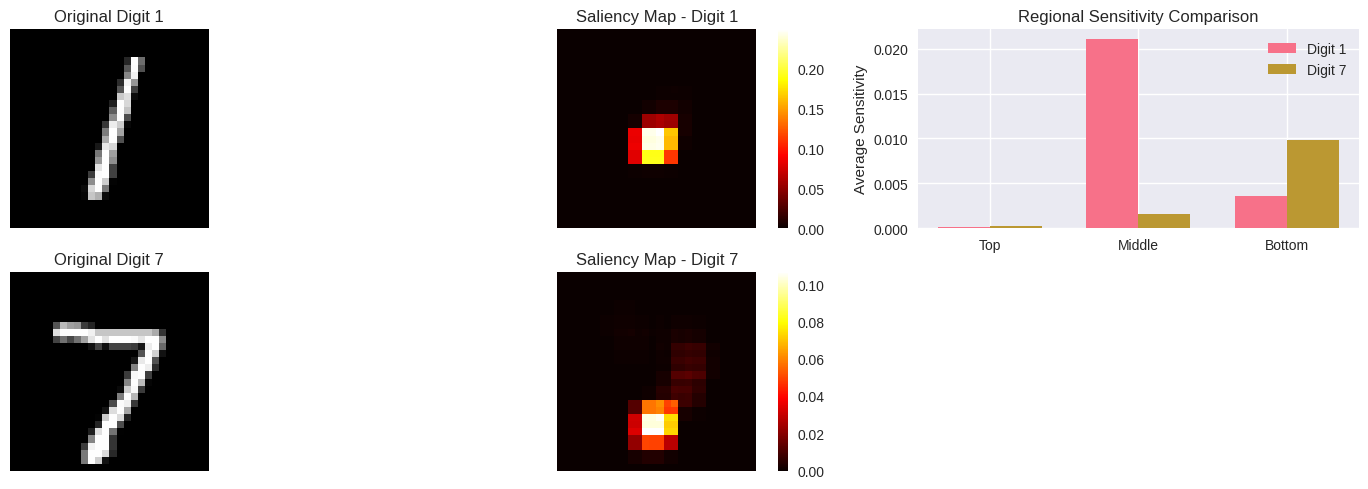


Numerical Results:

Digit 1 Regional Sensitivity:
Top: 0.0001
Middle: 0.0211
Bottom: 0.0035

Digit 7 Regional Sensitivity:
Top: 0.0002
Middle: 0.0016
Bottom: 0.0098

Statistical Analysis:
t-statistic: 2.8836
p-value: 0.0040


In [23]:
# Occlusion saliency map function
def generate_occlusion_map(model, image, label, patch_size=5):
    """
    Generate occlusion saliency map by systematically occluding parts of the image
    and measuring the change in classification confidence.
    """
    width, height = image.shape[2], image.shape[3]
    saliency_map = np.zeros((width, height))

    # Get original prediction confidence
    model.eval()
    with torch.no_grad():
        original_output = F.softmax(model(image), dim=1)[0, label].item()

    # Slide occlusion patch across image
    for w in range(0, width - patch_size + 1, 2):
        for h in range(0, height - patch_size + 1, 2):
            # Create occluded image
            occluded = image.clone()
            occluded[0, 0, w:w+patch_size, h:h+patch_size] = 0

            # Get new prediction
            with torch.no_grad():
                output = F.softmax(model(occluded), dim=1)[0, label].item()

            # Calculate sensitivity
            sensitivity = original_output - output
            saliency_map[w:w+patch_size, h:h+patch_size] += sensitivity

    return saliency_map

# Regional Sensitivity Analysis
digit_1 = None
digit_7 = None
label_1 = torch.tensor([1])
label_7 = torch.tensor([7])

for data, target in test_loader:
  for i in range(len(target)):
    if target[i] == 1 and digit_1 is None:
      digit_1 = data[i:i+1]
    elif target[i] == 7 and digit_7 is None:
      digit_7 = data[i:i+1]
  if digit_1 is not None and digit_7 is not None:
    break

# Generate saliency maps
saliency_1 = generate_occlusion_map(model, digit_1, 1)
saliency_7 = generate_occlusion_map(model, digit_7, 7)

# Visualize results
plt.figure(figsize=(15, 5))

# Original digits
plt.subplot(2, 3, 1)
plt.title('Original Digit 1')
plt.imshow(digit_1.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Original Digit 7')
plt.imshow(digit_7.squeeze(), cmap='gray')
plt.axis('off')

# Saliency maps
plt.subplot(2, 3, 2)
plt.title('Saliency Map - Digit 1')
plt.imshow(saliency_1, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Saliency Map - Digit 7')
plt.imshow(saliency_7, cmap='hot')
plt.colorbar()
plt.axis('off')

# Region analysis
def analyze_regions(saliency_map):
  height = saliency_map.shape[0]
  region_height = height // 3
  regions = {
      'top': np.mean(saliency_map[:region_height, :]),
      'middle': np.mean(saliency_map[region_height:2*region_height, :]),
      'bottom': np.mean(saliency_map[2*region_height:, :])
      }
  return regions

regions_1 = analyze_regions(saliency_1)
regions_7 = analyze_regions(saliency_7)

# Plot regional sensitivity comparison
plt.subplot(2, 3, 3)
plt.title('Regional Sensitivity Comparison')
x = np.arange(3)
width = 0.35

plt.bar(x - width/2, list(regions_1.values()), width, label='Digit 1')
plt.bar(x + width/2, list(regions_7.values()), width, label='Digit 7')
plt.xticks(x, ['Top', 'Middle', 'Bottom'])
plt.ylabel('Average Sensitivity')
plt.legend()

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nDigit 1 Regional Sensitivity:")
for region, value in regions_1.items():
  print(f"{region.capitalize()}: {value:.4f}")
print("\nDigit 7 Regional Sensitivity:")
for region, value in regions_7.items():
  print(f"{region.capitalize()}: {value:.4f}")

# Statistical analysis
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    saliency_1.flatten(),
    saliency_7.flatten()
    )

print(f"\nStatistical Analysis:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")